In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import sys
sys.path.append('common')
import json

from preprocessing import mean_and_std, normalizer, scaleminmax
from print_more_stuff import print_more_stuff
from writeresults import write_results

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor

import pandas as pd

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
outliers_df = pd.read_csv('outliers.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.head()

,bed,bath,acre_lot,zip_code,house_size,price,prev_sold_year,latitude,longitude,county
0,4.0,2.0,0.26,8016.0,1764.0,279000.0,2018.0,40.069522,-74.824196,18.0
1,3.0,2.0,0.22,8016.0,1988.0,299000.0,2016.0,40.069522,-74.824196,18.0
2,3.0,2.0,0.20,8016.0,1764.0,275000.0,2020.0,40.069522,-74.824196,18.0
3,5.0,2.0,0.05,8016.0,2104.0,219900.0,2007.0,40.069522,-74.824196,18.0
4,3.0,1.0,0.28,8016.0,1085.0,259000.0,2016.0,40.069522,-74.824196,18.0


In [4]:
switches = {
    "features":"lat&long",
    "which_normalize":"",
    "model":"Hist Gradient Boosting"
}
# "lat&long"  onezipcode onecounty outliers allzipcodes allcounties
# "scaleminmax_df" "normalizer_df" "mean_and_std_df"
# "Random Forest" "Hist Gradient Boosting" "Gradient Boosting" "Adaboost"

In [5]:
groupby_zipcode = outliers_df.groupby(["zip_code"])["zip_code"].count().sort_values(ascending=False)
groupby_zipcode_df = pd.DataFrame(groupby_zipcode).rename(columns={"zip_code":"count"}).reset_index()
first_zipcode = groupby_zipcode_df.iloc[0]["zip_code"]
first_zipcode

8527.0

In [6]:
one_zipcode_df = outliers_df[outliers_df["zip_code"].isin([first_zipcode])]

In [7]:
one_zipcode_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 269 entries, 10338 to 10606
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             269 non-null    float64
 1   bath            269 non-null    float64
 2   acre_lot        269 non-null    float64
 3   zip_code        269 non-null    float64
 4   house_size      269 non-null    float64
 5   price           269 non-null    float64
 6   prev_sold_year  269 non-null    float64
 7   latitude        269 non-null    float64
 8   longitude       269 non-null    float64
 9   county          269 non-null    float64
dtypes: float64(10)
memory usage: 23.1 KB


In [8]:
groupby_county = outliers_df.groupby(["county"])["county"].count().sort_values(ascending=False)
groupby_county_df = pd.DataFrame(groupby_county).rename(columns={"county":"count"}).reset_index()
first_county = groupby_county_df.iloc[0]["county"]
first_county

3.0

In [9]:
one_county_df = outliers_df[outliers_df["county"].isin([first_county])]

In [10]:
one_county_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2076 entries, 13052 to 19278
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             2076 non-null   float64
 1   bath            2076 non-null   float64
 2   acre_lot        2076 non-null   float64
 3   zip_code        2076 non-null   float64
 4   house_size      2076 non-null   float64
 5   price           2076 non-null   float64
 6   prev_sold_year  2076 non-null   float64
 7   latitude        2076 non-null   float64
 8   longitude       2076 non-null   float64
 9   county          2076 non-null   float64
dtypes: float64(10)
memory usage: 178.4 KB


In [11]:
params = {
    "data":outliers_df,
    "features_a":["prev_sold_year","zip_code","latitude","longitude","county"],
    "features_n":["bed","bath","acre_lot","house_size","price"]
}

match switches["features"]:
    case "onezipcode":
        params["data"] = one_zipcode_df
    case "onecounty":
        params["data"] = one_county_df
    case "allzipcodes":
        params["data"] = outliers_df
    case "allcounties":
        params["data"] = outliers_df
    case _:
        params["data"] = outliers_df

In [12]:
which_dataframe = outliers_df
match switches["which_normalize"]:
    case "mean_and_std_df":
        which_dataframe = mean_and_std(params)
    case "scaleminmax_df":
        which_dataframe = scaleminmax(params)
    case "normalizer_df":
        which_dataframe = normalizer(params)

which_dataframe.head()

,bed,bath,acre_lot,zip_code,house_size,price,prev_sold_year,latitude,longitude,county
0,4.0,2.0,0.26,8016.0,1764.0,279000.0,2018.0,40.069522,-74.824196,18.0
1,3.0,2.0,0.22,8016.0,1988.0,299000.0,2016.0,40.069522,-74.824196,18.0
2,3.0,2.0,0.20,8016.0,1764.0,275000.0,2020.0,40.069522,-74.824196,18.0
3,5.0,2.0,0.05,8016.0,2104.0,219900.0,2007.0,40.069522,-74.824196,18.0
4,3.0,1.0,0.28,8016.0,1085.0,259000.0,2016.0,40.069522,-74.824196,18.0


In [13]:
# "zip_code","latitude","longitude","county",
norm_features = ["acre_lot","bed","bath","house_size","prev_sold_year","price"]

match switches["features"]:
    case "allzipcodes":
        norm_features.append("zip_code")
    case "allcounties":
        norm_features.append("county")
    case "lat&long":
        norm_features.append("latitude")
        norm_features.append("longitude")
        
correlation = which_dataframe[norm_features].corr()
correlation["price"]

acre_lot          0.013009
bed               0.453542
bath              0.618459
house_size        0.361332
prev_sold_year    0.031241
price             1.000000
latitude          0.118985
longitude         0.270237
Name: price, dtype: float64

In [14]:
X = which_dataframe[norm_features]
X.drop(columns=["price"],inplace=True)
y = which_dataframe["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
if switches["model"] == "Hist Gradient Boosting":
    histgrboost = HistGradientBoostingRegressor()
    model_gscv = GridSearchCV(histgrboost, param_grid={})
    histgrboost_model = model_gscv.fit(X_train,y_train)
    model_predictions = histgrboost_model.predict(X_test)

In [16]:
if switches["model"] == "Gradient Boosting":
    grboost = GradientBoostingRegressor()
    model_gscv = GridSearchCV(grboost, param_grid={})
    grboost_model = model_gscv.fit(X_train,y_train)
    model_predictions = grboost_model.predict(X_test)

In [17]:
if switches["model"] == "Adaboost":
    adaboost = AdaBoostRegressor()
    model_gscv = GridSearchCV(adaboost, param_grid={})
    adaboost_model = model_gscv.fit(X_train,y_train)
    model_predictions = adaboost_model.predict(X_test)

In [18]:
if switches["model"] == "Random Forest":
    rf = RandomForestRegressor()
    model_gscv = GridSearchCV(rf, param_grid={})
    rf_model = model_gscv.fit(X_train,y_train)
    model_predictions = rf_model.predict(X_test)

In [19]:
pms_config = {
    "title":switches["model"],
    "y_param":y_test, 
    "predictions":model_predictions, 
    "gscv":model_gscv
}

In [20]:
results = print_more_stuff(pms_config)
results["features"] = switches["features"]
results["normalized"] = switches["which_normalize"]

Hist Gradient Boosting EVS = 0.718048047
Hist Gradient Boosting MSE = 50,759,356,575.610619
Hist Gradient Boosting MAE = 128,934.917338
Hist Gradient Boosting R2 = 0.718037
Hist Gradient Boosting Fit Time = 0.5146624565124511


In [21]:
predict_df = pd.DataFrame(model_predictions).reset_index()
predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

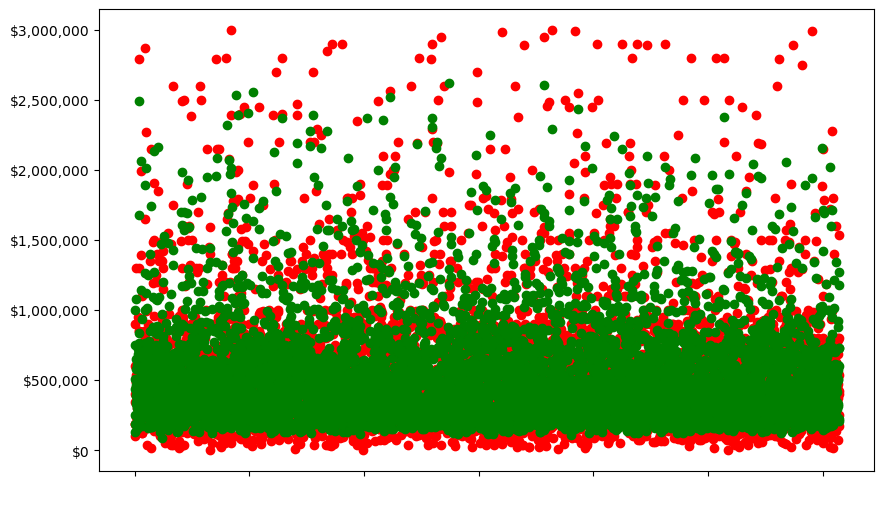

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(predict_df.index,predict_df["prediction"], color="green")
plt.show()

In [23]:
results

{'model': 'Hist Gradient Boosting',
 'explained variance score': '0.718048047',
 'mae score': '128,934.917338',
 'mse score': '50,759,356,575.610619',
 'r2 score': '0.718037',
 'mean fit time': 0.5146624565124511,
 'features': 'lat&long',
 'normalized': ''}

In [24]:
with open("nj/normalize.json", 'r+') as file:
        file_data = json.load(file)
        file_data.append(results)
        file.seek(0)
        json.dump(file_data, file, indent=4)

In [25]:
results_df = pd.read_json("nj/normalize.json")

model_comparisons = results_df.set_index('model').sort_values("r2 score", ascending=True)
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time,features,normalized
model,,,,,,,
Hist Gradient Boosting,0.481035,0.001929,0.000010,0.480975,0.188943,,normalizer_df
Hist Gradient Boosting,0.483043,0.449206,0.534636,0.483006,0.262972,,mean_and_std_df
Hist Gradient Boosting,0.489291,0.061268,0.009884,0.489262,0.273695,,scaleminmax_df
Hist Gradient Boosting,0.612969,0.050112,0.007492,0.612846,0.522150,allcounties,scaleminmax_df
Hist Gradient Boosting,0.652318,0.047352,0.006729,0.652299,0.546029,allzipcodes,scaleminmax_df
Gradient Boosting,0.661592,0.348391,0.350000,0.661549,0.727419,lat&long,mean_and_std_df
Hist Gradient Boosting,0.697179,0.001384,0.000006,0.697147,0.306650,lat&long,normalizer_df
Hist Gradient Boosting,0.717307,0.310369,0.292392,0.717257,0.625366,lat&long,mean_and_std_df
Hist Gradient Boosting,0.717493,0.042356,0.005467,0.717474,0.558953,lat&long,scaleminmax_df
